# Applying the classifier

A notebook to apply the classifier to your dataset and get some basic analysis. In particular, you can:

- Apply the final models to a catalog.
- Perform basic analysis, to produce:
    - color-magnitude diagrams
    - statistics
- Export results to file.

- - - 

## general imports 

In [4]:
import os
import sys
import glob
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import matplotlib.ticker as mticker


import pickle
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


def realgalname(gal):
    """A simple function to return the proper naming for each galaxy,
    ie add some space wherever necessary."""
    
    if 'NGC' in gal or 'IC' in gal:
        realID = gal.replace('C', 'C ')
    elif 'Sextans' in gal:
        realID = gal.replace('tans', 'tans ')
    elif 'Phoenix' in gal:
        realID = gal.replace('nix', 'nix Dwarf')
    elif 'Pegasus' in gal:
        realID = gal.replace('sus', 'sus DIG')
    else:
        realID = gal
    return realID

# 1. Check data for missing columns <a name='check' /></a> 
<div align="right"><a href=#top>top</a></div>

Some galaxies do not have any optical data. Therefore only the IR color is left and the imputer does no return a (X,5) array , but with a smaller second dimention. Then the rest of the scipt is failing since it is expecting values across all color terms. 

The current code (3 April 2024) aims to detect which galaxies experience what issues and then the `process_data` function tries to resolve these (eg by adding the mean values for each color as determined form the training sample). The imputer then repeats these values across all sources. This - obviously - cannot correct for this amount of missing values (as a whole). So this data is actually worthless since the band completeness is very low. 

In [8]:
# (code form 3/4/2024)

def check_galaxy(inputfile):
    """Quick function to check the completeness of the 
    color terms used."""
    data = pd.read_csv( inputfile )
#    print(data.columns)
    indxs = []
    for bnd in ['rMag', 'iMag', 'zMag', 'yMag', '3.6Mag', '4.5Mag', 'yMagVhs']:
        if bnd in data.columns:
            unique_values = data[bnd].unique()
            if len(unique_values)==1: # and unique_values==-999:
                print(f'    - {bnd} has problem - unique value of {unique_values}')
                indxs.append(bnd)
            else:
                print(f'    - no issue for {bnd} ({len(unique_values)} values)')
        else:
            print(f'    > {bnd} not in the column list!')
    
    print()
            

In [9]:
files = glob.glob('test_data/*_fnl.csv')

for g in files:
    print(f'>>> Working on {g.split("/")[1].split("_")[0]}')
    check_galaxy(g)

>>> Working on SextansA
    - no issue for rMag (656 values)
    - no issue for iMag (789 values)
    - no issue for zMag (701 values)
    - no issue for yMag (375 values)
    - no issue for 3.6Mag (444 values)
    - no issue for 4.5Mag (418 values)
    - no issue for yMagVhs (319 values)

>>> Working on NGC2403
    - no issue for rMag (2149 values)
    - no issue for iMag (2809 values)
    - no issue for zMag (2228 values)
    - no issue for yMag (1387 values)
    - no issue for 3.6Mag (522 values)
    - no issue for 4.5Mag (500 values)
    - yMagVhs has problem - unique value of [nan]



# 2. Run the classifier <a name='run' /></a> 
<div align="right"><a href=#top>top</a></div>

The Iterative Impoter is acting on the whole dataset to produce the ml_data_clrs data that are fed to the models.

The code assumes Gaia DR3 data format.  

_Note_: you can run for an individual galaxy or for all of them.

In [17]:
# list of colors to create: ['r-i', 'i-z', 'z-y', 'y-36', '36-45']
clrs_means = [-0.029749999999999943, 0.05940000000000012, 0.045700000000000074, 
             2.623099999999999, 0.004999999999999005]


missing_value = -999    # used in the following functions
imputer = IterativeImputer(missing_values=missing_value)

def import_data( dfile ):
    """A function to read the csv files with data (per galaxy). """
    
    print('- Reading data')

    # Assinging automatically the type for each column
    with open(dfile) as f:
        cols = len( f.readline().split(',') ) 

    # with DR3 we keep also the GaiaID 
    dt_dtype = int, 'S22', 'S10'
    for i in range(cols-3): #cols:
        dt_dtype +=   (float),
#    print(dt_dtype)    
        
    data = np.genfromtxt(dfile, unpack=True, comments='#', names=True, 
                        autostrip='Yes', filling_values=missing_value,
                        dtype=dt_dtype, delimiter=',',
                        )

    # This block replaces all problematic values (such as 0.0) with the missing value
    for b in [n for n in data.dtype.names[2:]]: 
    #    print(b)
        for i in range(len(data[b])):
            if data[b][i]==0.0 or data[b][i]==-1.0 or data[b][i]==99.99:
                #print(b)
                data[b][i] = missing_value

#    print(data.dtype.names)
    return data

def process_data( data ):
    """Processing the data file to produce the necessary arrays 
    for further consideration (along with any selection needed).
    """  
    print('- Processing data')

    # this is the hardcoded list of mags to use (no change)
    # this combination creates the color terms to work with
    bands_selected = ['rMag','iMag','zMag','yMag','36Mag', '45Mag']

    bands = [n for n in data.dtype.names if 'Mag' in n]
    errbands = [n for n in data.dtype.names if 'Mag' in n]
    print(data.dtype.names)
    
    
    ml_data_comp = []   # data completeness, i.e. how many bands have measurements 
    ml_data_clrs, tmp_clrs = [], []   # taking color indeces, as consecutive mag differences (next-previous)
    ml_labels = []
    ml_objects = []
    ml_data_ra, ml_data_dec = [], [] # RA, Dec coordinates of selected objects

    for star in np.arange(0,len(data),1):

        star_ID = data[star]['ID'] #.decode('UTF-8')
        mags = np.asarray(list(data[star][bands_selected]))
        comp_i = 0
        colors_n = len(mags)-1
        dif = []
        for i in range(colors_n):
            if mags[i+1]==missing_value or mags[i]==missing_value:
#                print('change to ', clrs_means[i])
#               dif.append(clrs_means[i]) 
                dif.append(missing_value)
                comp_i+=1
            else:
                dif.append(mags[i]-mags[i+1])
        comp = 1 - comp_i/colors_n
#        print(comp, comp_i, colors_n)

        
        tmp_clrs.append(dif)
        ml_data_comp.append(comp)
        ml_objects.append(star_ID)
    #    print(data[star]['SpT'])
        ml_data_ra.append(data[star]['RA'])
        ml_data_dec.append(data[star]['Dec'])  # DEC in DR2, Dec in DR3  
        
               
        if data[star]['SpT']==b'':
            label = 'na'
        else:
            label = data[star]['SpT'].decode('UTF-8')
        ml_labels.append(label)

    imputer.fit( tmp_clrs )
    ml_data_clrs = imputer.transform( tmp_clrs )  

    # Code to check if the imputer returns 5 columns or not.
    # Specific exceptions have been added and handled  
    check_shape = ml_data_clrs.shape

    print(f'- The shape of imputer output array is: {check_shape}')

    if check_shape[1]!=5:

        if galaxy in ['NGC300', 'Phoenix', 'NGC55', 'NGC1313']:
            print('!WARNING: only the IR color is available!')
            print('All missing (optical) colors will be replaced by their means.')

            if check_shape[1]==1:
                added_means = np.full((check_shape[0], 4), clrs_means[:4])
            else:
                print('ERROR: wtf?')

        elif galaxy=='NGC5253': 

            print('!WARNING: only the IR color and y VHS are available!')
            print('All other missing colors will be replaced by their means.')

            if check_shape[1]==2:
                added_means = np.full((check_shape[0], 3), clrs_means[:3])
            else:
                print('ERROR: wtf?')

        else:
            sys.exit(f'!ERROR: please check for {galaxy}, as shape is inconsistent!\n(tip: check list in code to add galaxy)')


        ml_data_clrs = np.hstack( (added_means, ml_data_clrs))
    
#    print(ml_data_clrs)
    
    return np.asarray(ml_data_clrs), np.asarray(ml_data_comp), np.asarray(ml_objects), np.asarray(ml_labels), np.asarray(ml_data_ra), np.asarray(ml_data_dec), bands


def apply_models( data2use, dfile ):
    """Function to load the full trained models for the three methods
    and apply them to the data.
    The results are written on an external file for independent 
    processing later on. 
    
    CAUTION: the spt list should be the same with the one when training. 
    """
    print('- Applying models:', end=" ")

    spt = ['BSG', 'BeBR', 'GAL', 'LBV', 'RSG', 'WR', 'YSG'] 
    methods = ['SVC','RF','MLP']
    
    ml_data_clrs, ml_labels, ml_objects, ml_data_comp = data2use[0], data2use[3], data2use[2], data2use[1] 

    
    for m in methods:
        model = f'models/M31+M33_full_model-{m}.sav'
        print(f'{m}', end=" ")

        if m=='RF':
            loaded_model_RF = pickle.load(open(model, 'rb'))
            probs_RF = loaded_model_RF.predict_proba(ml_data_clrs) 
            preds_RF = loaded_model_RF.predict(ml_data_clrs)

        elif m=='SVC':
            loaded_model_SVC = pickle.load(open(model, 'rb'))
            probs_SVC = loaded_model_SVC.predict_proba(ml_data_clrs) 
            preds_SVC = loaded_model_SVC.predict(ml_data_clrs)            
            
        elif m=='MLP':
            loaded_model_MLP = pickle.load(open(model, 'rb'))
            probs_MLP = loaded_model_MLP.predict_proba(ml_data_clrs) 
            preds_MLP = loaded_model_MLP.predict(ml_data_clrs) 
            
    print()
    # saving results offline
    output = dfile.replace('.csv','-results.csv')
    
   
    header = f"ID,Original_Class,\
SVC_Class,{','.join(['probSVC-'+i for i in spt])},\
RF_Class,{','.join(['probRF-'+i for i in spt])},\
MLP_Class,{','.join(['probMLP-'+i for i in spt])},\
Final_Class,Final_Prob,Band_Compl,\
{','.join(['probTotal-'+i for i in spt])}\n"
           
    f = open(output, "w")
    f.write(header)
        
    for preRF, preSVC, preMLP, probRF, probSVC, probMLP, origClass, name, dt_compl in zip(preds_RF, preds_SVC, preds_MLP, probs_RF, probs_SVC, probs_MLP, ml_labels, ml_objects, ml_data_comp):

        total_prob = probRF*0.33 + probSVC*0.33 + probMLP*0.33
        prob = np.max(total_prob)
        result = spt[np.argmax(total_prob)]
        
        wrt_syntax = ('{},'*12).rstrip(',')+"\n"
        f.write( wrt_syntax.format(name,origClass,
                             spt[preSVC],str(probSVC.tolist()).strip('[]'),
                             spt[preRF],str(probRF.tolist()).strip('[]'),
                             spt[preMLP],str(probMLP.tolist()).strip('[]'),
                             result, prob, dt_compl,
                             str(total_prob.tolist()).strip('[]')) )
        

    f.close()  

    print(f'- All results saved to: \n{output}')            

In [20]:
galfileS = glob.glob("test_data/*_fnl.csv")

for galfile in galfileS:
#    print('='*45)
    galaxy = (galfile.split('/')[1]).split('_')[0] 
    print(f'>>> {galaxy} <<<' )
    galdata = process_data( import_data(galfile) )
#    print(galdata)
    
    apply_models( galdata, galfile )
    
    print('- Combining to a single catalog:')
#     # read data and results files
    d1 = pd.read_csv( galfile, dtype={'Gaia_DR3_id': 'str'})
    d2 = pd.read_csv( galfile.replace('_fnl.csv','_fnl-results.csv') )
    # remove SpT from data and ID from results
    d1.drop(columns=['SpT'], inplace=True)
    d2.drop(columns=['ID'], inplace=True)
    # moving GaiaID after coordinates
    col_Gaia = d1.pop('Gaia_DR3_id')
    d1.insert(3, 'Gaia_DR3_id', col_Gaia)
    # combining the two tables
    comb = pd.concat([d1, d2], axis=1)
    
    # removing duplicates 
#     print('  ... removing duplicates')
#     try:
#         dup = pd.read_csv( galfile.replace('_fnl.csv','_dup.txt'), delimiter='\t')
#         toRemove = dup['ID1'].unique()
#         comb_cln = comb[~comb['ID'].isin(toRemove)]
#     except FileNotFound:
#         print(f"!WARNING: {galfile.replace('_fnl.csv','_dup.txt')} not found")
#         continue
        
    # saving file
    save_file = galfile.replace('_fnl.csv','_catalog.csv')
#    comb_cln.to_csv(save_file, index=False)
    comb.to_csv(save_file, index=False)
    print(save_file)
    
    print('='*45+'\n')

>>> SextansA <<<
- Reading data
- Processing data
('ID', 'Gaia_DR3_id', 'SpT', 'RA', 'Dec', 'pmRA', 'pmRAErr', 'pmDec', 'pmDecErr', 'parallax', 'parallaxErr', '36Mag', '36MagErr', '45Mag', '45MagErr', '58Mag', '58MagErr', '80Mag', '80MagErr', '24Mag', '24MagErr', 'gMag', 'gMagErr', 'rMag', 'rMagErr', 'iMag', 'iMagErr', 'zMag', 'zMagErr', 'yMag', 'yMagErr', 'JMagUhs', 'JMagUhsErr', 'yMagVhs', 'yMagErrVhs', 'jMagVhs', 'jMagVhsErr', 'hMagVhs', 'hMagVhsErr', 'ksMagVhs', 'ksMagVhsErr', 'gMagGaia', 'bpMag', 'rpMag')


/home/grigoris/.local/lib/python3.7/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


- The shape of imputer output array is: (2848, 5)
- Applying models: SVC RF MLP 
- All results saved to: 
test_data/SextansA_fnl-results.csv
- Combining to a single catalog:
test_data/SextansA_catalog.csv

>>> NGC2403 <<<
- Reading data
- Processing data
('ID', 'Gaia_DR3_id', 'SpT', 'RA', 'Dec', 'pmRA', 'pmRAErr', 'pmDec', 'pmDecErr', 'parallax', 'parallaxErr', '36Mag', '36MagErr', '45Mag', '45MagErr', '58Mag', '58MagErr', '80Mag', '80MagErr', '24Mag', '24MagErr', 'gMag', 'gMagErr', 'rMag', 'rMagErr', 'iMag', 'iMagErr', 'zMag', 'zMagErr', 'yMag', 'yMagErr', 'JMagUhs', 'JMagUhsErr', 'yMagVhs', 'yMagErrVhs', 'jMagVhs', 'jMagVhsErr', 'hMagVhs', 'hMagVhsErr', 'ksMagVhs', 'ksMagVhsErr', 'gMagGaia', 'bpMag', 'rpMag')
- The shape of imputer output array is: (15936, 5)
- Applying models: SVC RF MLP 
- All results saved to: 
test_data/NGC2403_fnl-results.csv
- Combining to a single catalog:
test_data/NGC2403_catalog.csv



# 3. CMDs and statistics per galaxy<a name='analyse' /></a> 
<div align="right"><a href=#top>top</a></div>

This part reads the cataog file to plot individual CMDs and statistics per galaxy.

**CAUTION**: when selecting bands keep in mind that only r, i, z, y, 3.6, 4.5 are used to determine band completeness. So other bands may not be complete, even if selecting those with band completeness = 1 (that will mean that all r...4.5 bands exist, but not the rest).  

**NOTE**: in the CMDs we are plotting sources based on the **input** data, i.e. existing values from photometry. By performing data imputation we can _get_ some values for the missing features but these are not shown in those plots. 

In [23]:
# # CAUTION: this list should be the same with the one when training. 
spt = ['BSG', 'BeBR', 'GAL', 'LBV', 'RSG', 'WR', 'YSG'] 

def distmod( gal_dist ):
    """ To convert apparent to absolute magnitudes
    we need to use distance modulus, defined as:
    dm m-M = 5 log10( d/10 pc)
    This function return dm for any galaxy 
    given its distance."""
    
    return 5*np.log10( gal_dist*100000)          

def prettifymag( amag ):
    """Quick text conversion function for 
    prettier mag output 
    """
    if '.' in amag:
        newmag='['+amag[0:3]+']'
    elif 'Gaia' in amag:
        newmag='G'
    else:
        newmag = amag[0:2].strip('M')
    return newmag


def cmd_plots( bands2use, min_prob, min_bc, dist, drct ):
    """
    Rewrite the docstring ....
    
    Given the list of colors (as subarrays of two bands)
    it plots and saves the CMDs. 
    The minimum probability to consider must be provided. 
    """

    selprob = gdt[ (gdt['Final_Prob']>=min_prob)    # probability cut
                 & (gdt['Band_Compl']>=min_bc) ]    # bc cut   

    selmags = selprob[ bands2use + ['Final_Class'] ]  
    mags = selmags[ selmags.notna().all(axis=1) ] # removing any NaN point (not able to plot)

    print(f'  -- number of sources with selected mags: {selmags.shape[0]}')
    print(f'  -- minimun completeness: {minCompl}' )
    print(f'  -- minimum probability: {min_prob}')

    plt.rcParams.update({'font.size':25})
    # setting plotting parameters per class
    #spt =    ['BSG', 'BeBR',      'GAL', 'LBV',   'RSG', 'WR',     'YSG'] 
#    pltsmbs = ['x',   '2',         'o',   '3',      '+',  '4',      '1']
    pltsmbs = ['X',   'D',         'o',   '<',      '.',  '>',      'v']

    pltclrs = ['b',  'darkviolet', 'k',   'violet', 'r',  'purple', 'y']


    fig, ax = plt.subplots(1,2, figsize=(20,15))


    bbax = 0
    for bb in range(0,len(bands2use),2):
#        print(bb, bands2use[bb])
        b1 = bands2use[bb]
        b2 = bands2use[bb+1]
#        print(b1, b2)    

        # iterating over spectral classes
        for i in range(len(spt)):
#            print(spt[i])
            mag1 = mags[ mags['Final_Class']==spt[i] ][b1]
            mag2 = mags[ mags['Final_Class']==spt[i] ][b2]
#            print(mag1)
            ax[bbax].plot(mag1-mag2, mag2, 'bo', ms=15,
                    marker=pltsmbs[i], 
                     markerfacecolor='none', # full symbols
#                    fillstyle='full',       # for line symbols
                    color=pltclrs[i], 
                    label=f'{spt[i]} ({len(mag2)})'
                    )
       
    
        ax[bbax].invert_yaxis()
        ax[bbax].set_xlabel(f'{prettifymag(b1)}-{prettifymag(b2)}')
        ax[bbax].set_ylabel(f'{prettifymag(b2)}')
    #             ax.set_xticks(fontsize=20)
    #             ax.set_yticks(fontsize=20)          
        ax[bbax].legend(fontsize=17)
        
        # adding a second axis with absolute values
        ax2 = ax[bbax].twinx()
        ax2.set_ylabel(f'M$_{{{prettifymag(b2)}}}$')
                       
        Mag22 = mag2-distmod(dist)

        ax2.set_ylim(max(Mag22), min(Mag22)) 
        ax2.yaxis.set_ticks_position('right')
        
        
        bbax += 1

    fig.suptitle(realgalname(galaxy))
    plt.tight_layout()
    plt.savefig(f'{drct}/{galaxy}_cmds.png')
    plt.show()       

#### INPUTS:

*minProb2keep*: 
 Minimum probability to keep with possible mean values: 0.51 and 0.60 for the distribution of incorrect classifications for the three test galaxies and the training (M31+M33) sample, as well as 0.67 and 0.86 for the distribution of the correct classifications for the test and training sets, respectively. (See paper image on test galaxies distributions)
Currently, using the **0.66** limit ...

*minCompl2keep*:
 The list of band completeness to keep. This is actually an index. The possible numbers for the completeness are: 1.0,0.8,0.6,0.4,0.2 (with none,1,2,3,4 missing features, respectively). Selecting a number we actually select the index of the array to keep. 
E.g. 0 is the first ([1.0]), 1 would correspond to [1.0,0.8]) 

**CAUTION**: a galaxy may not contain all the values listed above (eg [1.0, 0.4]). In this case the above approach is wrong 

**2DO**: 
- (correct the above:) set a limit on the completeness itself (perhaps per gralaxy ?). 
- closing the plots (?) , sometimes they get messy...


### A. CMDs (single and batch mode)

In [24]:
def cmd_plots( bands2use, min_prob, min_bc, dist, drct ):
    """
    Rewrite the docstring ....
    
    """

    selprob = gdt[ (gdt['Final_Prob']>=min_prob)    # probability cut
                 & (gdt['Band_Compl']>=min_bc) ]    # bc cut 

    selmags = selprob[ bands2use + ['Final_Class', 'ID'] ] 
    mags = selmags[ selmags.notna().all(axis=1) ] # removing any NaN point (not able to plot)
    
    if selmags.shape[0]==0:
        print(f'!WARNING: no good candidates to produce plot - skipping')
        return 

    print(f'  -- number of sources with selected mags: {selmags.shape[0]}')
    print(f'  -- minimun completeness: {minCompl}' )
    print(f'  -- minimum probability: {min_prob}')

    plt.rcParams.update({'font.size':25})
    # setting plotting parameters per class
    #spt =    ['BSG', 'BeBR',      'GAL', 'LBV',   'RSG', 'WR',     'YSG'] 
#    pltsmbs = ['x',   '2',         'o',   '3',      '+',  '4',      '1']
    pltsmbs = ['o',   'd',         '1',   'p',      '+',  '^',      'v']

    pltclrs = ['cyan', 'b', 'dimgray',   'g',       'r',  'none', 'yellow']
    
    pltsize = [ 14,    16,         16,    18,       16,   16,      14 ]

    pltbord = ['grey', 'none',   'dimgray', 'none',  'r', 'purple', 'k'] 

    pltzord = [ 4,    6,            1,     7,         2,    3,        5]    

    fig, ax = plt.subplots(1,2, figsize=(20,15))


    bbax = 0
    for bb in range(0,len(bands2use),2):
#        print(bb, bands2use[bb])
        b1 = bands2use[bb]
        b2 = bands2use[bb+1]
#        print(b1, b2)    

        # iterating over spectral classes
        for i in range(len(spt)):
#            print(spt[i])
            mag1 = mags[ mags['Final_Class']==spt[i] ][b1]
            mag2 = mags[ mags['Final_Class']==spt[i] ][b2]
#            print(mag1)
            ax[bbax].plot(mag1-mag2, mag2, 'bo', 
                    ms=16, #pltsize[i],
                    marker=pltsmbs[i],
#                     markerfacecolor='none', # full symbols
#                    fillstyle='full',       # for line symbols
                    markerfacecolor=pltclrs[i], 
                    markeredgecolor=pltbord[i],                          
#                    color=pltclrs[i], 
#                    alpha = 0.7,
                    zorder=pltzord[i],                          
                    label=f'{spt[i]} ({len(mag2)})')
            
        ax[bbax].invert_yaxis()
        ax[bbax].set_xlabel(f'${prettifymag(b1)}$-${prettifymag(b2)}$ (mag)', fontsize=30)
        ax[bbax].set_ylabel(f'${prettifymag(b2)}$ (mag)', fontsize=30)
    #             ax.set_xticks(fontsize=20)
    #             ax.set_yticks(fontsize=20)          
        ax[bbax].legend(fontsize=18)

        # adding a second axis with absolute values
        ax2 = ax[bbax].twinx()
        ax2.set_ylabel(f'M$_{{{prettifymag(b2)}}}$ (mag)', fontsize=30)

        Mag22 = mag2-distmod(dist)

        ax2.set_ylim(max(Mag22), min(Mag22)) 
        ax2.yaxis.set_ticks_position('right')


        bbax += 1

    fig.suptitle(realgalname(galaxy), fontsize=32)
    plt.tight_layout()
#    plt.savefig(f'{drct}/{galaxy}_cmds.png')

#    plt.savefig(f'{drct}/{galaxy}_cmds.pdf')
#    plt.close()
    
    plt.show()  


>>> SextansA <<<
- Initial number of sources in catalog: 2848
- Plotting CMDs, using
  -- number of sources with selected mags: 175
  -- minimun completeness: 0.6
  -- minimum probability: 0.66


/home/grigoris/.local/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


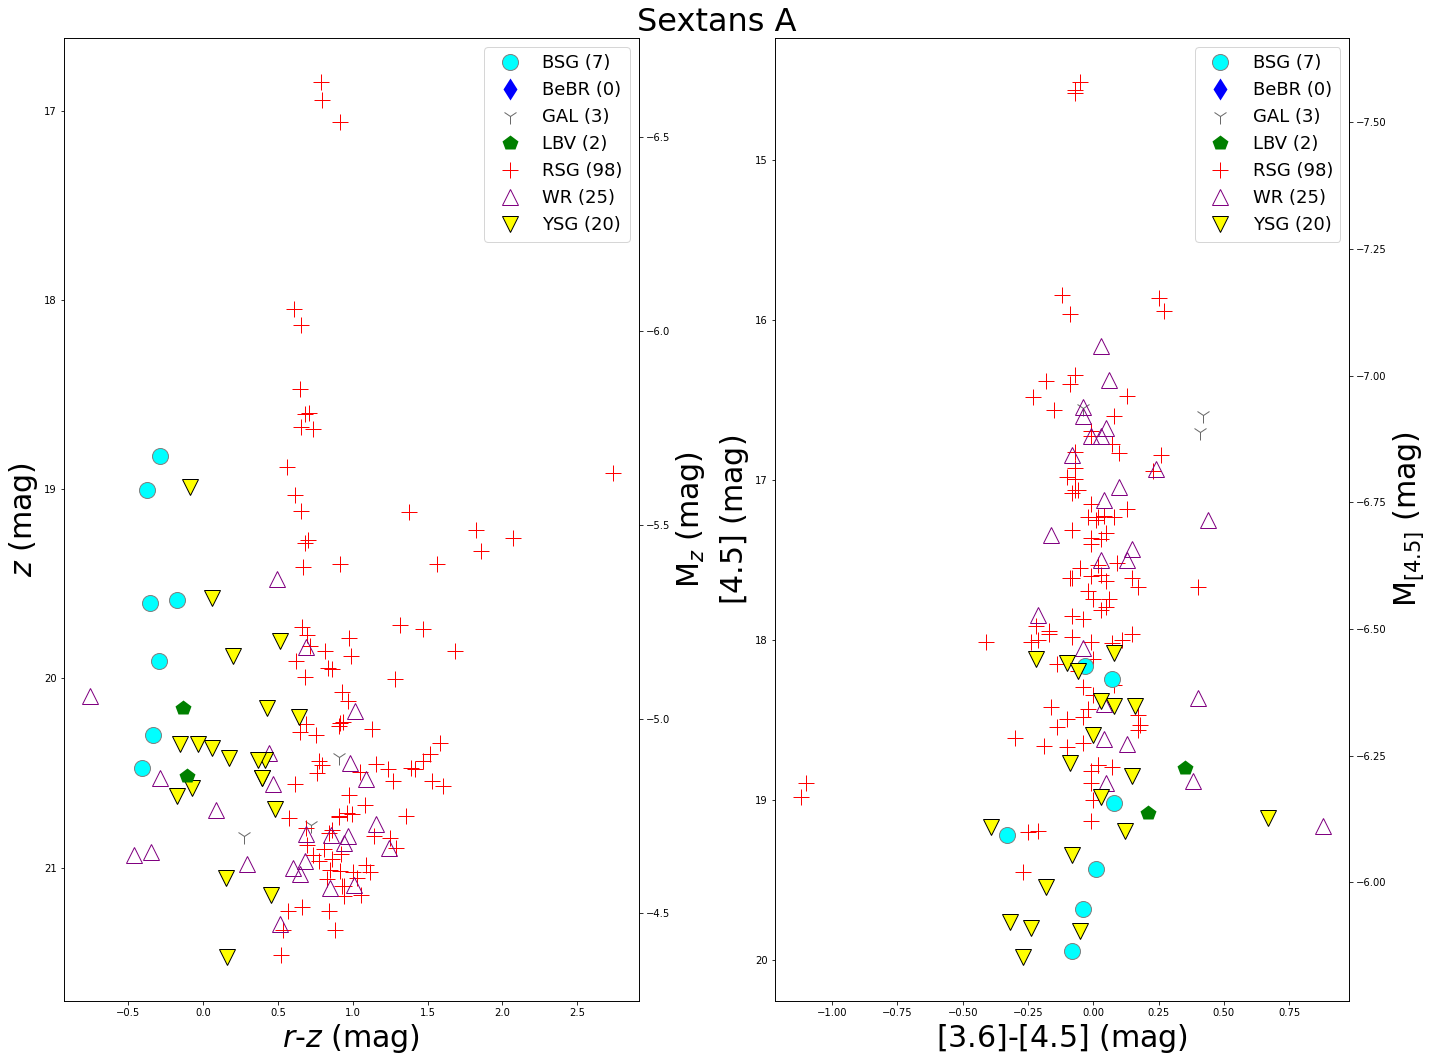

In [26]:
minProb = 0.66
minCompl = 0.6

# result statistics
gals = glob.glob('test_data/SextansA_catalog.csv')

# galaxy properties
props = pd.read_csv( 'test_data/galaxy_properties.dat')  

for gal in gals: #[0:1]:
    print('='*45)
    galaxy = (gal.split('/')[1]).split('_')[0] 
    folder = gal.split('/')[0]
    print(f'>>> {galaxy} <<<' )
    
    gdt = pd.read_csv( gal )
    print(f'- Initial number of sources in catalog: {gdt.shape[0]}')

    distance = props[props['galaxy']==galaxy]['distance'].values[0]
    
    # select CMDs to plot
    # **CAUTION**: when selecting bands keep in mind that only 
    # r, i, z, y, 3.6, 4.5 are used to determine band completeness. 
    # So other bands may not be complete, even if selecting those 
    # with band completeness = 1 (that will mean that all r...4.5 
    # bands exist, but not the rest). 
    print('- Plotting CMDs, using')
    cmds = ['rMag','zMag', '3.6Mag', '4.5Mag' ]
    
    
    cmd_plots( cmds, minProb, minCompl, distance, folder)
    
